In [1]:
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
train = pd.read_csv("train.zip", index_col=['id'])
test = pd.read_csv("test.zip", index_col=['id'])
sample_submission = pd.read_csv("sample_submission.zip", index_col=['id'])


In [2]:
print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [3]:
train.head(5)



,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

train.author = train.author.replace(['EAP', 'HPL', 'MWS'], ['Едгар', 'Хауърд', 'Мери'])



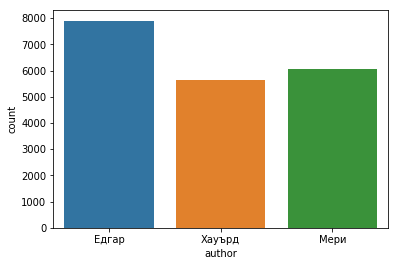

In [5]:
sns.countplot(data=train, x='author');



In [6]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score



In [7]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)



array([ 0.78783701,  0.79635305,  0.79509579])

In [8]:
pipeline.fit(train.text, train.author)
count_vectorizer = pipeline.steps[0][1]
count_vectorizer



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.81449142  0.81673307  0.81348659]
[-0.47678351 -0.4755887  -0.47131399]


In [10]:
from sklearn.neural_network import MLPClassifier

In [11]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', MLPClassifier())
])

In [12]:
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.78599877  0.78577996  0.78390805]
[-1.07137215 -1.12785611 -1.18148449]


In [13]:
import nltk
explore = train.copy()
explore.text.apply(lambda s: ' '.join(nltk.word_tokenize(s)))


id
id26305    This process , however , afforded me no means ...
id17569    It never once occurred to me that the fumbling...
id11008    In his left hand was a gold snuff box , from w...
id27763    How lovely is spring As we looked from Windsor...
id12958    Finding nothing else , not even gold , the Sup...
id22965    A youth passed in solitude , my best years spe...
id09674    The astronomer , perhaps , at this point , too...
id13515         The surcingle hung in ribands from my body .
id19322    I knew that you could not say to yourself 'ste...
id00912    I confess that neither the structure of langua...
id16737    He shall find that I can feel my injuries ; he...
id16607    Here we barricaded ourselves , and , for the p...
id19764    Herbert West needed fresh bodies because his l...
id18886    The farm like grounds extended back very deepl...
id17189    But a glance will show the fallacy of this idea .
id12799    He had escaped me , and I must commence a dest...
id08441    To these s

In [14]:
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


'''pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 2), 
                                    min_df=1,
                                    max_df=0.7,
                                    lowercase=False)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.text, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))'''


"pipeline = Pipeline([\n    ('features', TfidfVectorizer(analyzer = 'word',\n                                    stop_words=nltk.corpus.stopwords.words('english'),\n                                    ngram_range=(1, 2), \n                                    min_df=1,\n                                    max_df=0.7,\n                                    lowercase=False)),\n     ('clf', MultinomialNB(alpha=0.1))\n])\nprint(cross_val_score(pipeline, explore.text, explore.author, cv=3, n_jobs=3, \n                      scoring='neg_log_loss'))"

In [15]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }
    params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True]}
                      
    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),)),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

In [16]:
random_search()

Model with rank: 1
Mean validation score: -0.477 (std: 0.005)
Parameters: {'features__ngram_range': (1, 2), 'features__analyzer': 'word', 'clf__alpha': 0.01, 'features__lowercase': True, 'features__min_df': 3, 'features__max_df': 0.6}

Model with rank: 1
Mean validation score: -0.477 (std: 0.005)
Parameters: {'features__ngram_range': (1, 2), 'features__analyzer': 'word', 'clf__alpha': 0.01, 'features__lowercase': True, 'features__min_df': 3, 'features__max_df': 0.5}

Model with rank: 3
Mean validation score: -0.496 (std: 0.004)
Parameters: {'features__ngram_range': (1, 3), 'features__analyzer': 'word', 'clf__alpha': 0.01, 'features__lowercase': False, 'features__min_df': 5, 'features__max_df': 0.6}

Model with rank: 4
Mean validation score: -0.502 (std: 0.003)
Parameters: {'features__ngram_range': (1, 3), 'features__analyzer': 'word', 'clf__alpha': 0.1, 'features__lowercase': True, 'features__min_df': 5, 'features__max_df': 1.0}

Model with rank: 5
Mean validation score: -0.504 (std: 0

In [17]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 3), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.text, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))


[-0.45755117 -0.45451807 -0.45192547]


In [18]:
# не рън-вай, че таз мреа мн се чака, а като цяло е зле
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 3), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MLPClassifier(alpha=0.1))
])
print(cross_val_score(pipeline, explore.text, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))


[-0.51980125 -0.51404569 -0.50762974]


In [19]:
explore = train.copy()
explore['preprocessed'] = explore.text.apply(lambda s: " ".join("%s%s" % tup for tup in nltk.pos_tag(nltk.word_tokenize(s))))

explore['preprocessed']


id
id26305    ThisDT processNN ,, howeverRB ,, affordedVBD m...
id17569    ItPRP neverRB onceRB occurredVBD toTO mePRP th...
id11008    InIN hisPRP$ leftJJ handNN wasVBD aDT goldJJ s...
id27763    HowWRB lovelyRB isVBZ springJJ AsIN wePRP look...
id12958    FindingVBG nothingNN elseRB ,, notRB evenRB go...
id22965    ADT youthNN passedVBN inIN solitudeNN ,, myPRP...
id09674    TheDT astronomerNN ,, perhapsRB ,, atIN thisDT...
id13515    TheDT surcingleNN hungNN inIN ribandsNNS fromI...
id19322    IPRP knewVBD thatIN youPRP couldMD notRB sayVB...
id00912    IPRP confessVBP thatIN neitherCC theDT structu...
id16737    HePRP shallMD findVB thatIN IPRP canMD feelVB ...
id16607    HereRB wePRP barricadedVBD ourselvesPRP ,, and...
id19764    HerbertNNP WestNNP neededVBD freshJJ bodiesNNS...
id18886    TheDT farmNN likeIN groundsNNS extendedVBN bac...
id17189    ButCC aDT glanceNN willMD showVB theDT fallacy...
id12799    HePRP hadVBD escapedVBN mePRP ,, andCC IPRP mu...
id08441    ToTO these

In [20]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 3), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[-0.42748916 -0.42438677 -0.42681112]


In [21]:

def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }
    params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True]}
                      
    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),)),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(explore.preprocessed, explore.author)
    report(random_search.cv_results_)

In [22]:
random_search()

Model with rank: 1
Mean validation score: -0.427 (std: 0.001)
Parameters: {'features__ngram_range': (1, 3), 'features__analyzer': 'word', 'clf__alpha': 0.1, 'features__lowercase': False, 'features__min_df': 2, 'features__max_df': 0.7}

Model with rank: 2
Mean validation score: -0.428 (std: 0.001)
Parameters: {'features__ngram_range': (1, 3), 'features__analyzer': 'word', 'clf__alpha': 0.1, 'features__lowercase': False, 'features__min_df': 2, 'features__max_df': 0.8}

Model with rank: 3
Mean validation score: -0.430 (std: 0.005)
Parameters: {'features__ngram_range': (1, 2), 'features__analyzer': 'word', 'clf__alpha': 0.01, 'features__lowercase': False, 'features__min_df': 2, 'features__max_df': 0.6}

Model with rank: 4
Mean validation score: -0.443 (std: 0.004)
Parameters: {'features__ngram_range': (1, 3), 'features__analyzer': 'word', 'clf__alpha': 0.01, 'features__lowercase': True, 'features__min_df': 2, 'features__max_df': 0.8}

Model with rank: 5
Mean validation score: -0.445 (std: 

In [23]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 2), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[-0.42797688 -0.421668   -0.42459543]


In [24]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 3), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MLPClassifier(alpha=0.1, hidden_layer_sizes = (100,)))
])
print(cross_val_score(pipeline, explore.text, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[-0.52120283 -0.51131894 -0.51006827]


In [25]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 3), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.83884804  0.83818572  0.84030651]
[-0.42748916 -0.42438677 -0.42681112]


In [26]:
explore_backup = explore.copy()
explore_backup.head(2)

,text,author,preprocessed
id,,,
id26305,"This process, however, afforded me no means of...",Едгар,"ThisDT processNN ,, howeverRB ,, affordedVBD m..."
id17569,It never once occurred to me that the fumbling...,Хауърд,ItPRP neverRB onceRB occurredVBD toTO mePRP th...


In [27]:
explore['phrasing'] = explore.text.apply(lambda s: " ".join("%s" % tup[1] for tup in nltk.pos_tag(nltk.word_tokenize(s))))

In [28]:
explore['phrasing'].head(3)

id
id26305    DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...
id17569       PRP RB RB VBD TO PRP IN DT NN MD VB DT JJ NN .
id11008    IN PRP$ JJ NN VBD DT JJ NN NN , IN WDT , IN PR...
Name: phrasing, dtype: object

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kotuzov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [31]:
explore['lemmatized'] = explore.text.apply(lambda s: " ".join("%s" % lemmatizer.lemmatize(word) for word in nltk.word_tokenize(s)))

In [32]:
explore['lemmatized'].head(3)

id
id26305    This process , however , afforded me no mean o...
id17569    It never once occurred to me that the fumbling...
id11008    In his left hand wa a gold snuff box , from wh...
Name: lemmatized, dtype: object

In [33]:
#тоз лематизатор е мн мн зле
explore_backup = explore.copy()
explore_backup.head(1)

,text,author,preprocessed,phrasing,lemmatized
id,,,,,
id26305,"This process, however, afforded me no means of...",Едгар,"ThisDT processNN ,, howeverRB ,, affordedVBD m...","DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...","This process , however , afforded me no mean o..."


In [34]:
y = explore['author']
X = explore.drop(['text', 'author', 'preprocessed'], axis = 1 )



In [35]:
X.head()

,phrasing,lemmatized
id,,
id26305,"DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...","This process , however , afforded me no mean o..."
id17569,PRP RB RB VBD TO PRP IN DT NN MD VB DT JJ NN .,It never once occurred to me that the fumbling...
id11008,"IN PRP$ JJ NN VBD DT JJ NN NN , IN WDT , IN PR...","In his left hand wa a gold snuff box , from wh..."
id27763,WRB RB VBZ JJ IN PRP VBD IN NNP NNP IN DT JJ J...,How lovely is spring As we looked from Windsor...
id12958,"VBG NN RB , RB RB NN , DT NNP VBD PRP$ NNS : C...","Finding nothing else , not even gold , the Sup..."


In [36]:
y.head()

id
id26305     Едгар
id17569    Хауърд
id11008     Едгар
id27763      Мери
id12958    Хауърд
Name: author, dtype: object

In [37]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

In [38]:
sum(X.lemmatized.value_counts()), sum(y.value_counts())

(19579, 19579)

In [39]:
#в последващите опити съм използвал векторайзера подготвен за двете колони 'phrasing' и lemmatized',
# само върху колонката 'preprocessed', защо така, ами объркал съм с какво тренирам, видях че съм в грешка,
# но все пак ми подобрява скора реших да си поиграя малко с хиперпараметрите

In [40]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                                        ('phrasing',
                                               TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 2), 
                                                                
                                                                lowercase=True)),
                                        ('lemmatized',
                                                TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 2), 
                                                                lowercase=True)   
                                                    )
                                    ])),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.84742647  0.84845234  0.84030651]
[-0.40515771 -0.39951364 -0.41681723]


In [41]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                                        ('phrasing',
                                               TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 2),
                                                                max_df=0.7,
                                                                lowercase=True)),
                                        ('lemmatized',
                                                TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 2), 
                                                                lowercase=True)   
                                                    )
                                    ])),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.8471201   0.84860558  0.83969349]
[-0.40515177 -0.39943733 -0.41685359]


In [42]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



def random_search():
    params = {
        "clf__alpha": [0.001, 0.01, 0.1, 0.5, 1, 2]
    }
    params_count_word = {"features__phrasing__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__phrasing__analyzer": ['word'],
                      "features__phrasing__max_df":[1, 0.9, 0.8, 0.7, 0.6],
                      "features__phrasing__lowercase": [False, True],
                      "features__lemmatized__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__lemmatized__analyzer": ['word'],
                      "features__lemmatized__max_df":[0.8, 0.7, 0.6, 0.5, 0.4],
                      "features__lemmatized__lowercase": [False, True] 
                        }
                      
    params.update(params_count_word)

    pipeline = Pipeline([
    ('features', FeatureUnion([
                                        ('phrasing',
                                               TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                min_df = 0
                                                                )),
                                        ('lemmatized',
                                                TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                
                                                               )   
                                                    )
    ])),
     ('clf', MultinomialNB())
])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(explore.preprocessed, explore.author)
    report(random_search.cv_results_)

In [43]:
random_search()

Model with rank: 1
Mean validation score: -0.403 (std: 0.007)
Parameters: {'features__phrasing__analyzer': 'word', 'features__phrasing__lowercase': True, 'features__lemmatized__lowercase': False, 'features__lemmatized__analyzer': 'word', 'features__phrasing__max_df': 0.7, 'clf__alpha': 0.1, 'features__phrasing__ngram_range': (1, 2), 'features__lemmatized__max_df': 0.4, 'features__lemmatized__ngram_range': (1, 2)}

Model with rank: 2
Mean validation score: -0.414 (std: 0.007)
Parameters: {'features__phrasing__analyzer': 'word', 'features__phrasing__lowercase': True, 'features__lemmatized__lowercase': True, 'features__lemmatized__analyzer': 'word', 'features__phrasing__max_df': 0.8, 'clf__alpha': 0.1, 'features__phrasing__ngram_range': (1, 2), 'features__lemmatized__max_df': 0.4, 'features__lemmatized__ngram_range': (1, 3)}

Model with rank: 3
Mean validation score: -0.430 (std: 0.008)
Parameters: {'features__phrasing__analyzer': 'word', 'features__phrasing__lowercase': True, 'features__

In [44]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                                        ('phrasing',
                                               TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range= (1, 1),
                                                                max_df=0.7,
                                                                lowercase=False)),
                                        ('lemmatized',
                                                TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 2), 
                                                                max_df=0.8,
                                                                lowercase=False)   
                                                    )
                                    ])),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, explore.preprocessed, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.85003064  0.85442844  0.84873563]
[-0.37615715 -0.36891552 -0.38519335]


In [45]:
еxplore_test = test.copy()
еxplore_test['preprocessed'] = еxplore_test.text.apply(lambda s: " ".join("%s%s" % tup for tup in nltk.pos_tag(nltk.word_tokenize(s))))


In [46]:
еxplore_test.head(5)

,text,preprocessed
id,,
id02310,"Still, as I urged our leaving Ireland with suc...","StillRB ,, asIN IPRP urgedVBD ourPRP$ leavingV..."
id24541,"If a fire wanted fanning, it could readily be ...","IfIN aDT fireNN wantedVBD fanningNN ,, itPRP c..."
id00134,And when they had broken down the frail door t...,AndCC whenWRB theyPRP hadVBD brokenVBN downRP ...
id27757,While I was thinking how I should possibly man...,WhileIN IPRP wasVBD thinkingVBG howWRB IPRP sh...
id04081,I am not sure to what limit his knowledge may ...,IPRP amVBP notRB sureJJ toTO whatWP limitVB hi...


In [47]:
pipeline = pipeline.fit(explore.preprocessed, explore.author)



In [48]:
sample_submission = pd.read_csv("sample_submission.zip")
sample_submission.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [49]:
print(pipeline.predict_proba(еxplore_test[:10].preprocessed))

[[  1.48665137e-02   9.84131310e-01   1.00217639e-03]
 [  9.95451318e-01   3.34141033e-04   4.21454143e-03]
 [  1.28009778e-01   3.33402095e-03   8.68656201e-01]
 [  8.86143678e-01   6.82360768e-04   1.13173961e-01]
 [  6.51794868e-01   9.29924042e-02   2.55212728e-01]
 [  9.82755645e-01   5.96227061e-04   1.66481277e-02]
 [  7.38770736e-01   1.43166442e-02   2.46912620e-01]
 [  1.75980023e-03   9.32070668e-01   6.61695322e-02]
 [  9.99056615e-01   2.36637610e-06   9.41018833e-04]
 [  9.32773166e-01   6.05444503e-02   6.68238390e-03]]


In [50]:
test_predictions = pipeline.predict_proba(еxplore_test.preprocessed)

In [51]:
submit_file = pd.DataFrame(test_predictions, columns=['EAP', 'MWS', 'HPL'], index=test.index)
submit_file.head(10)

,EAP,MWS,HPL
id,,,
id02310,0.014867,0.984131,0.001002
id24541,0.995451,0.000334,0.004215
id00134,0.128010,0.003334,0.868656
id27757,0.886144,0.000682,0.113174
id04081,0.651795,0.092992,0.255213
id27337,0.982756,0.000596,0.016648
id24265,0.738771,0.014317,0.246913
id25917,0.001760,0.932071,0.066170
id04951,0.999057,0.000002,0.000941


In [52]:
submit_file.to_csv("submit_Tfidf_MNB_text.csv") # тая работа здраво овърфитва

In [53]:
# ще се опитам да си подкарам featureUnion върху 'phrasing' и lemmatized', както исках да направя в началото
X.head()

,phrasing,lemmatized
id,,
id26305,"DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...","This process , however , afforded me no mean o..."
id17569,PRP RB RB VBD TO PRP IN DT NN MD VB DT JJ NN .,It never once occurred to me that the fumbling...
id11008,"IN PRP$ JJ NN VBD DT JJ NN NN , IN WDT , IN PR...","In his left hand wa a gold snuff box , from wh..."
id27763,WRB RB VBZ JJ IN PRP VBD IN NNP NNP IN DT JJ J...,How lovely is spring As we looked from Windsor...
id12958,"VBG NN RB , RB RB NN , DT NNP VBD PRP$ NNS : C...","Finding nothing else , not even gold , the Sup..."


In [55]:
feature_transformer = FeatureUnion([
                                        ('phrasing',
                                               TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 3), 
                                                                lowercase=True)),
                                        ('lemmatized',
                                                TfidfVectorizer(analyzer = 'word',
                                                                stop_words=nltk.corpus.stopwords.words('english'),
                                                                ngram_range=(1, 3), 
                                                                lowercase=True)   
                                                    )
                                    ])

In [56]:
features = feature_transformer.fit(X).transform(X)

In [57]:
print(features) # тва няма как да е правилно

  (0, 1)	1.0
  (0, 3)	1.0
  (1, 0)	1.0
  (1, 2)	1.0


In [58]:
preprocessed_features = TfidfVectorizer(analyzer = 'word',
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    ngram_range=(1, 2), 
                                    min_df=2,
                                    max_df=0.7,
                                    lowercase=True).fit(explore_backup.preprocessed).transform(explore_backup.preprocessed)

In [59]:
print(preprocessed_features)

  (0, 70534)	0.158736018024
  (0, 70529)	0.0923334212922
  (0, 68896)	0.168187004138
  (0, 68893)	0.141783362204
  (0, 67001)	0.114711097531
  (0, 65382)	0.16533500168
  (0, 64157)	0.0638805598688
  (0, 63288)	0.0335840395615
  (0, 62176)	0.181011193203
  (0, 61936)	0.0568797103537
  (0, 60749)	0.129714436942
  (0, 59498)	0.137803501823
  (0, 57994)	0.128233535273
  (0, 52987)	0.175688673843
  (0, 52883)	0.0705975625983
  (0, 50909)	0.175688673843
  (0, 50908)	0.151234348318
  (0, 50493)	0.168187004138
  (0, 50462)	0.0863211733545
  (0, 48774)	0.150040295713
  (0, 48768)	0.124105068519
  (0, 46331)	0.147861145367
  (0, 45491)	0.104554250565
  (0, 44635)	0.134530037086
  (0, 43566)	0.0896280233571
  :	:
  (19578, 50494)	0.143667917756
  (19578, 50462)	0.125868635276
  (19578, 42693)	0.164422828718
  (19578, 42631)	0.0849177880889
  (19578, 40717)	0.0414705748841
  (19578, 39769)	0.206740450946
  (19578, 39752)	0.0770419748578
  (19578, 38282)	0.237479747289
  (19578, 37753)	0.0704448543

In [60]:
X['phrasing_features'] = TfidfVectorizer(analyzer = 'word',
                    stop_words=nltk.corpus.stopwords.words('english'),
                    ngram_range=(1, 2), 
                    min_df = 0,
                    max_df = 1,
                    lowercase=True).fit(X.phrasing).transform(X.phrasing)

In [61]:
print(X['phrasing_features'])

id
id26305      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id17569      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id11008      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id27763      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id12958      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id22965      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id09674      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id13515      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id19322      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id00912      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id16737      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id16607      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id19764      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id18886      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id17189      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id12799      (200, 0)\t1.0\n  (537, 56)\t1.0\n  (1074, 13...
id08441      (200, 0)

In [62]:
X['lemmatized_features'] = TfidfVectorizer(analyzer = 'word',
                       stop_words=nltk.corpus.stopwords.words('english'),
                       ngram_range=(1, 2), 
                       max_df=0.8,
                       lowercase=False).fit(X.lemmatized).transform(X.lemmatized)

In [63]:
print(X['lemmatized_features'])

id
id26305      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id17569      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id11008      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id27763      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id12958      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id22965      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id09674      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id13515      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id19322      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id00912      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id16737      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id16607      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id19764      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id18886      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id17189      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id12799      (0, 236421)\t0.175727022943\n  (0, 236391)\t...
id08441      (0, 2364

In [64]:
# направих ги ръчно щото featureUnion-а нещо не ме харесва
X.head(1)

,phrasing,lemmatized,phrasing_features,lemmatized_features
id,,,,
id26305,"DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...","This process , however , afforded me no mean o...","(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."


In [65]:
NB = MultinomialNB(alpha=0.1)
X.drop(['phrasing','lemmatized'], axis = 1)


,phrasing_features,lemmatized_features
id,,
id26305,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id17569,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id11008,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id27763,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id12958,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id22965,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id09674,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id13515,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."
id19322,"(200, 0)\t1.0\n (537, 56)\t1.0\n (1074, 13...","(0, 236421)\t0.175727022943\n (0, 236391)\t..."


In [67]:
#NB.fit(X, y)
# не става...

In [68]:
# ще се опитвам да варя някакви статистики от текста...

In [69]:
explore = explore_backup.copy()
explore.head(5)

,text,author,preprocessed,phrasing,lemmatized
id,,,,,
id26305,"This process, however, afforded me no means of...",Едгар,"ThisDT processNN ,, howeverRB ,, affordedVBD m...","DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P...","This process , however , afforded me no mean o..."
id17569,It never once occurred to me that the fumbling...,Хауърд,ItPRP neverRB onceRB occurredVBD toTO mePRP th...,PRP RB RB VBD TO PRP IN DT NN MD VB DT JJ NN .,It never once occurred to me that the fumbling...
id11008,"In his left hand was a gold snuff box, from wh...",Едгар,InIN hisPRP$ leftJJ handNN wasVBD aDT goldJJ s...,"IN PRP$ JJ NN VBD DT JJ NN NN , IN WDT , IN PR...","In his left hand wa a gold snuff box , from wh..."
id27763,How lovely is spring As we looked from Windsor...,Мери,HowWRB lovelyRB isVBZ springJJ AsIN wePRP look...,WRB RB VBZ JJ IN PRP VBD IN NNP NNP IN DT JJ J...,How lovely is spring As we looked from Windsor...
id12958,"Finding nothing else, not even gold, the Super...",Хауърд,"FindingVBG nothingNN elseRB ,, notRB evenRB go...","VBG NN RB , RB RB NN , DT NNP VBD PRP$ NNS : C...","Finding nothing else , not even gold , the Sup..."


In [70]:
explore['punctuation_count'] = explore.phrasing.apply(lambda s: s.count(','))

In [71]:
explore.punctuation_count.head(10)

id
id26305    4
id17569    0
id11008    4
id27763    3
id12958    2
id22965    4
id09674    3
id13515    0
id19322    7
id00912    2
Name: punctuation_count, dtype: int64

In [72]:
y = explore.author
X = explore.copy()


In [73]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [74]:
vectorizer.fit(X.phrasing)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [75]:
vectorizer.vocabulary_

{'cc': 0,
 'cc cc': 1,
 'cc cd': 2,
 'cc dt': 3,
 'cc ex': 4,
 'cc fw': 5,
 'cc in': 6,
 'cc jj': 7,
 'cc jjr': 8,
 'cc jjs': 9,
 'cc md': 10,
 'cc nn': 11,
 'cc nnp': 12,
 'cc nnps': 13,
 'cc nns': 14,
 'cc pdt': 15,
 'cc pos': 16,
 'cc prp': 17,
 'cc rb': 18,
 'cc rbr': 19,
 'cc rbs': 20,
 'cc to': 21,
 'cc uh': 22,
 'cc vb': 23,
 'cc vbd': 24,
 'cc vbg': 25,
 'cc vbn': 26,
 'cc vbp': 27,
 'cc vbz': 28,
 'cc wdt': 29,
 'cc wp': 30,
 'cc wrb': 31,
 'cd': 32,
 'cd cc': 33,
 'cd cd': 34,
 'cd dt': 35,
 'cd ex': 36,
 'cd in': 37,
 'cd jj': 38,
 'cd jjr': 39,
 'cd jjs': 40,
 'cd md': 41,
 'cd nn': 42,
 'cd nnp': 43,
 'cd nns': 44,
 'cd pdt': 45,
 'cd pos': 46,
 'cd prp': 47,
 'cd rb': 48,
 'cd to': 49,
 'cd vb': 50,
 'cd vbd': 51,
 'cd vbg': 52,
 'cd vbn': 53,
 'cd vbp': 54,
 'cd vbz': 55,
 'cd wdt': 56,
 'cd wp': 57,
 'cd wrb': 58,
 'dt': 59,
 'dt cc': 60,
 'dt cd': 61,
 'dt dt': 62,
 'dt ex': 63,
 'dt fw': 64,
 'dt in': 65,
 'dt jj': 66,
 'dt jjr': 67,
 'dt jjs': 68,
 'dt md': 69,
 'dt 

In [76]:
explore['phrase_vec'] = explore.phrasing.apply(lambda s: vectorizer.transform(s.split(' ')))

In [77]:
explore['phrase_vec'].head(5)

id
id26305      (0, 59)\t1.0\n  (1, 282)\t1.0\n  (3, 467)\t1...
id17569      (0, 434)\t1.0\n  (1, 467)\t1.0\n  (2, 467)\t...
id11008      (0, 139)\t1.0\n  (1, 434)\t1.0\n  (2, 172)\t...
id27763      (0, 856)\t1.0\n  (1, 467)\t1.0\n  (2, 769)\t...
id12958      (0, 675)\t1.0\n  (1, 282)\t1.0\n  (2, 467)\t...
Name: phrase_vec, dtype: object

In [78]:
X = explore['phrase_vec']

In [79]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(analyzer = 'word',
                                    ngram_range=(1, 2), 
                                    lowercase=False)),
     ('clf', MultinomialNB(alpha=0.1))
])
print(cross_val_score(pipeline, explore.phrasing, explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[-0.9622037  -0.9606053  -0.96014828]
